#  コンテンツ
- 全周ベジエ近似についての考察
- 曲率関数
- 段階的近似

## 1. 全周ベジエ近似についての考察


ベジエ曲線は円などの閉曲線を正確に記述することはできない。（複数のセグメントに分けて区分的に近似することはできる）

また、始点、終点をどこにでも設定できるため回転不変性はないので、全周を近似するためには、人間が始点・終点を指定するか、あるいは回転不変な特徴点を基準にして始点・終点を定めざるを得ない。逆に言えば、そのような点が設定できるのであれば自動で近似可能であるとも言える。

例えば、

- 曲率最大点
- 重心から最短の輪郭点。逆に最遠の輪郭点
- 最も遠い輪郭点のペアのうちの１点

などが考えられる。

下のプログラムでは、 曲率に準じる方法として、ハリスコーナー検出 により求めたコーナを基準にして全周ベジエ近似を試みている。


## 2. 曲率関数

パラメトリック曲線の曲率は、

$$\frac{1}{R}=\frac{(x'(t)y''(t) - y'(t)x''(t))}{(x'(t)^2 + y'(t)^2)^{3/2}}$$

で表せる。ベジェ曲線もパラメトリック曲線であるので、この式が有効である。


-　[曲率・曲率半径 (curvature and radius of curvature)](http://w3e.kanazawa-it.ac.jp/math/category/kika/heimenkika/henkan-tex.cgi?target=/math/category/kika/heimenkika/curvature.html)

-　[ベジェ曲線の曲率](http://geom.web.fc2.com/geometry/bezier/curvature.html)


## 3. 段階的近似

ベジエ近似において、各サンプル点に対するパラメータが既知であれば、制御点は単純な最小自乗法で求めうる。

すなわち、、制御点座標を未知数として自乗誤差を定義し、各制御点座標を表す変数による微係数＝０という連立方程式をとけば良い。

この方程式は単純な線形方程式になるので容易に解ける。

問題はパラメータが未知であるという点である。


rdlib2 のベジエ近似関数　　**fitBezierCurveN** では、

1. 輪郭に沿って測った基準点からの距離を総距離で除した値をパラメータ推定の初期値とし、これを固定して近似曲線を求める。
2. 各サンプル点に対し、求められた近似曲線上の最寄り点のパラメータによりそのサンプル点に紐付けるパラメータを更新する。
3. 新たなパラメータを用いて誤差を定義し直し、再近似する。

２.３を紐づけパラメータの変化が十分小さくなるまで繰り返す。

という手法を取った。

この過程でベジエ近似の次数は最初から最後まで一貫して指定された次数を用いているが、別の考え方として、

1. 上の手順で２次ベジエ近似を完了する。すなわちN=2。
2. N次のベジエ近似で決まった推定パラメータを初期値として、N+1次のベジエ近似を行うl
3. 指定された次数に達するまで１つずつ次数をあげていく。

という方法も考えられる。

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

In [2]:
%%time
def DemoW(img,samples=64,Nfrom=3,Nto=12,maxTry=3,prefunc=None):
    cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
    # 画像の全周の輪郭線を抽出　（S5参照）
    conAll = rd.getCntPairWithImg(img, mode=1)
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    
    bezAll = rd.BezierCurve(N=Nfrom,samples=Samples,prefunc=prefunc)
    fig = plt.figure(figsize =(6, 6)) 
    
    N = Nfrom
    while N <= Nto:
        print(N,end="")
        # M 回あてはめを繰り返す
        cps,fall = bezAll.fit1(maxTry=maxTry)
        # 結果を描画
        rd.drawBez0(img,stt=0.00,end=1.0,bezL=fall,cntL=Samples,ct=cts[(N-3)%10],bzlabel=str(N)) 
        # 次数を上げてインスタンス生成
        N = N+1
        bezAll = rd.BezierCurve(N=N,samples=Samples,prefunc=fall)
    print("")
    plt.legend()
    return fall 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [ ]:
    # 段階的ベジエ近似　    
    def fit2(self,Nfrom=3,Nto=12, maxTry = 10,prefunc = None,errorThres=0.5,withError=False,tpara=[],withFig=False):
        # Nfrom 近似開始次数
        # Nto 最大近似次数 Nto < Nfrom  の場合は誤差しきい値による打ち切り
        # maxTry 各次数での繰り返し回数
        # prefunc 初期近似関数
        # errorThres 打ち切り誤差
        # withError 誤差と次数を返すかどうか

        Ncurrent = Nfrom
        func = prefunc
        ts = tpara
        err = errorThres + 1
        while Ncurrent <= Nto and  errorThres < err :
            abez = BezierCurve(N=Ncurrent,samples=self.samples, prefunc = func)
            print(Ncurrent,end="")
            # 最大 maxTry 回あてはめを繰り返す
            cps,func,err = abez.fit1(maxTry=maxTry,withError=True,tpara=ts)
            ts = abez.ts
            # 次数を上げてインスタンス生成
            Ncurrent = Ncurrent + 1
        if withError:
            return cps,func,Ncurrent,err
        else:
            return cps,func



10...

11...

12...

13...

14...


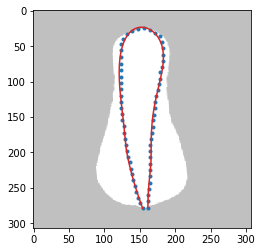

In [10]:
conAll = rd.getCntPairWithImg(imgs[3], mode=1)
Samples = rd.getSamples(conAll,N=64,mode='Equidistant')
bezAll = rd.BezierCurve(N=3,samples=Samples)
cps,func = bezAll.fit2(Nfrom=10,Nto=14,prefunc=func)
rd.drawBez0(imgs[0],stt=0.00,end=1.0,bezL=func,cntL=Samples) 

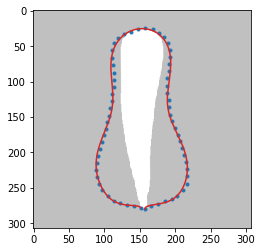

In [9]:
bezAll2 = rd.BezierCurve(N=14,samples=Samples)
cps2,func2 = bezAll2.fit0()
rd.drawBez0(imgs[3],stt=0.00,end=1.0,bezL=func2,cntL=Samples) 


7...

8...

9...

10...




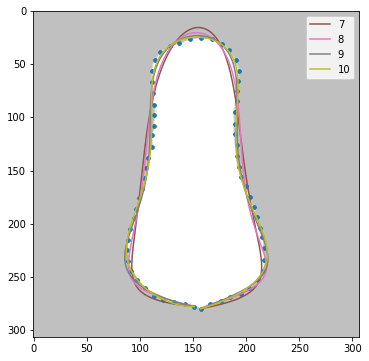

In [12]:
fall = DemoW(imgs[0],samples=64,Nfrom=7,Nto=10,maxTry=3,prefunc=fall)


7...

8...

9...

10...




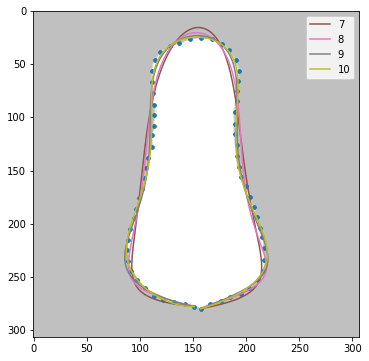

In [6]:
fall = DemoW(imgs[0],samples=64,Nfrom=7,Nto=10,maxTry=3,prefunc=fall)


11...

12...

13...

14...




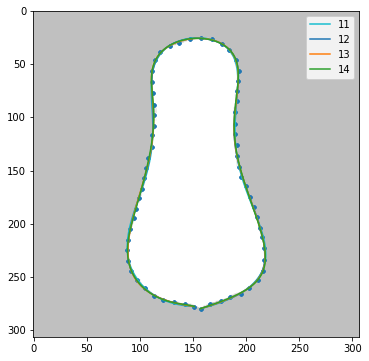

In [9]:
fall = DemoW(imgs[0],samples=64,Nfrom=11,Nto=14,maxTry=3,prefunc=fall)

# M次からN次までの段階的近似

In [2]:
UNIT=256
def test(path,M=3,N=15,tpara = [], samplespans=100,precPara=0.1,debugmode=True,overwrap=False):
    
    src = cv2.imread(path,cv2.IMREAD_GRAYSCALE) # グレイで読み込み
    rdimg = getstandardShape(src, unitSize=UNIT) # 適度に平滑化した２値画像を作成 
    
    c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(rdimg) # 重心とバウンディングボックスと面積
    
    _image, contours, _hierarchy = cv2.findContours(rdimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭

    # （平滑化した上で）尻尾の尖端座標を求める
    c_x,c_y,t_x,t_y = getCoGandTip(rdimg, showResult=True, useOldImage=True)

    # 尖端位置に半径１０の円を描き、輪郭に切れ目を入れる　（結果を目視しやすくするために半径７で半幅３の円を描くことで実質半径１０
    canvas = np.zeros_like(rdimg)
    canvas = cv2.drawContours(canvas,[cnt00],-1,255,1)
    rdCimg = cv2.circle(canvas,(int(t_x),int(t_y)),7,100,3) # 円を灰色で描く

    # 尖端に残る切れ端を取り除くため、ラベルづけして最大領域を抜き出す
    _ret,rdCimg = cv2.threshold(rdCimg,200,255,cv2.THRESH_BINARY)
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(rdCimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    rdCimg=((labelimg==areamax)*255).astype(np.uint8) # 長い輪郭だけの画像

    # 輪郭線画像の輪郭線追跡
    _, contours, hierarchy = cv2.findContours(rdCimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    cnt0=contours[0] # 領域は１つしかないので０番で間違いないはず
    
    # 分岐のない線図形の輪郭は、トレースが端点から始まれば１箇所、途中からなら２箇所折り返しがある。端点と折り返し、
    # もしくは、折り返しと折り返しの間を取り出すことで、重複のない輪郭データとする
    i1 = 0
    for i in range(int(len(cnt0))-1):
        if np.all(cnt0[i-1] == cnt0[i+1]):
            # print("折り返し点",i)
            i0,i1= i1,i
    cnt0 = cnt0[i0:i1+1]
    if cnt0[0][0][0] > cnt0[-1][0][0]: # contours はかっこが２重なので注意
        cnt0 = cnt0[::-1] # もし輪郭先頭画素が末端画素より右にあれば逆順にする
    # ２重カッコを１重に変換
    cnt0 = [[x,y] for [[x,y]] in cnt0]    

    # 輪郭点を一定間隔でサンプリング して標本を10１つくる　（ぐるっと１００分割）
    cnt1 = (np.array(cnt0))[list(map(int,np.linspace(0, len(cnt0)-1,samplespans+1)))]
    #result1,cpx,cpy,bezX1,bezY1,tp = fitBezierCurveN(cnt1[:61],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result2,cpx,cpy,bezX2,bezY2,tp = fitBezierCurveN(cnt1[60:],precPara=0.02,N=6,openmode=False,debugmode=True)
    #result3,cpx,cpy,bezX3,bezY3,tp = fitBezierCurveN(cnt1[30:91],precPara=0.02,N=6,openmode=False,debugmode=True)

    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    
    # 初期パラメータを等間隔で作成
    if len(tpara) == 0:
        initpara = makeInitialPara(cnt1)
    else:
        initpara = tpara
    
    print("N=",M)
    result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=initpara, precPara=precPara,N=M,openmode=False,debugmode=debugmode)

    bez = MyBezier(bezfunc=(bezX,bezY))
    # bez0.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if M<N else False))
    
    for nrank in range(M+1,N+1):
        if overwrap:
            print("Drawing",nrank-1,(True if nrank<N-1 else False))
            bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=(True if nrank-1<N else False))
        print("N=",nrank)
        result,cpx,cpy,bezX,bezY,tpara = fitBezierCurveN2(cnt1,initialpara=tpara, precPara=precPara,N=nrank,openmode=False,debugmode=debugmode)
        bez = MyBezier(bezfunc=(bezX,bezY))
        bez.nextcolor = nrank % 8
        
    bez.drawBez(rdimg=rdimg,n_samples=len(cnt1),cnt=cnt1,tpara=tpara,cont=False)
    
    return tpara,bez

# kyokuritsu # R = (x'(t)^2 + y'(t)^2)^(3/2)/(x'(t)*y''(t) - y'(t)*x''(t))

# 曲率計算



In [9]:
bezX,bezY = bez.bezfunc
diffX1 = diff(bezX,t)
diffY1 = diff(bezY,t)
diffX2 = diff(diffX1,t)
diffY2 = diff(diffY1,t)
R = (diffX1*diffX1+diffY1*diffY1)**(3/2)/(diffX1*diffY2-diffY1*diffX2)
Rinv = 1/R

# 曲率をパラメータの関数としてグラフ化

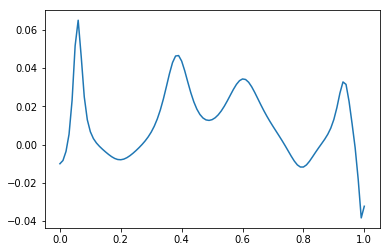

In [10]:
kyokuritsu = [Rinv.subs(t,s) for s in np.linspace(0,1,101)]
plt.plot(np.linspace(0,1,101),kyokuritsu)

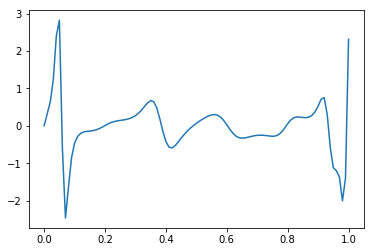

In [11]:
# 極値を求めるために曲率を微分しグラフ化
diffRinv=diff(Rinv,t)
RinvS=simplify(diffRinv)
plt.plot(np.linspace(0,1,101),[RinvS.subs(t,s) for s in np.linspace(0,1,101)])

In [12]:
# findroot 関数で求解するには　変数がxでないといけないようなので、t　を　x　に置き換え
from scipy import optimize
from sympy import lambdify
x = var('x')
RinvS.subs(t,x)

-(((3186727.21358514*x**12 + 61743088.0526275*x**11*(x - 1) + 154456408.443426*x**10*(x - 1)**2 - 881141543.392411*x**9*(x - 1)**3 - 3851318739.66575*x**8*(x - 1)**4 - 5317688148.00973*x**7*(x - 1)**5 - 3361089699.7526*x**6*(x - 1)**6 - 857673059.165976*x**5*(x - 1)**7 + 328349050.405228*x**4*(x - 1)**8 + 631626861.244584*x**3*(x - 1)**9 + 325695621.004932*x**2*(x - 1)**10 + 50652183.7167648*x*(x - 1)**11 + 1275248.21255871*(x - 1)**12)*(1436.9817286681*x**14 + 56833.2430592036*x**13*(x - 1) + 1255826.71389048*x**12*(x - 1)**2 + 6746048.12326418*x**11*(x - 1)**3 + 16490346.4526125*x**10*(x - 1)**4 + 13896532.9919754*x**9*(x - 1)**5 + 17000129.5379644*x**8*(x - 1)**6 + 35679137.6465859*x**7*(x - 1)**7 + 22305949.7609493*x**6*(x - 1)**8 - 13286882.3978584*x**5*(x - 1)**9 - 19699579.1512404*x**4*(x - 1)**10 - 6883022.19196168*x**3*(x - 1)**11 - 1203517.34041076*x**2*(x - 1)**12 - 55926.2975659664*x*(x - 1)**13 - 1445.70149369552*(x - 1)**14) - (4250848.42193784*x**12 + 109621956.923564*x*

# findroot solver 

数値解法で解を求める

https://docs.sympy.org/0.7.0/modules/mpmath/calculus/optimization.html?highlight=findroot#mpmath.findroot

In [17]:
# 曲率の高い点を７点求めてみる

mp.dps = 100
ans1 =  findroot(lambda x:RinvS.subs(t,x),0.05,solver='mnewton')
ans2 = findroot(lambda x:RinvS.subs(t,x),0.25,solver='mnewton')
ans3 = findroot(lambda x:RinvS.subs(t,x),[0.26,0.4],solver='ridder')
ans4 =  findroot(lambda x:RinvS.subs(t,x),0.42,solver='mnewton')
ans5 = findroot(lambda x:RinvS.subs(t,x),0.5)
ans6 = findroot(lambda x:RinvS.subs(t,x),0.8,solver='halley')
ans7 =  findroot(lambda x:RinvS.subs(t,x),[0.9,0.98],solver='ridder')
ans1,ans2,ans3,ans4,ans5,ans6,ans7

(mpf('0.05850141541454999'),
 mpf('0.19758397437285478'),
 mpf('0.3856515636965859'),
 mpf('0.48889538888029779'),
 mpf('0.60266648293248942'),
 mpf('0.79498710236796766'),
 mpf('0.93362935287426352'))

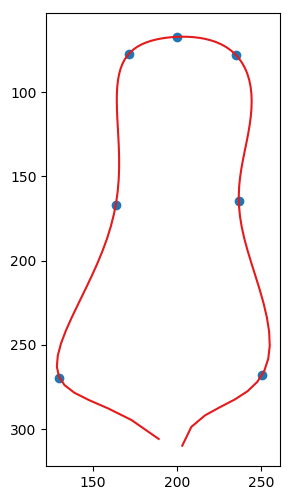

In [18]:
# 曲率の高い点をプロット
    
plt.figure(figsize=(6,6),dpi=100)
plt.gca().invert_yaxis() 
plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
bez.drawBez()
X1 = bez.bezfunc[0].subs(t,ans1)
Y1=bez.bezfunc[1].subs(t,ans1)
X2 = bez.bezfunc[0].subs(t,ans2)
Y2=bez.bezfunc[1].subs(t,ans2)
X3 = bez.bezfunc[0].subs(t,ans3)
Y3=bez.bezfunc[1].subs(t,ans3)
X4 = bez.bezfunc[0].subs(t,ans4)
Y4=bez.bezfunc[1].subs(t,ans4)
X5 = bez.bezfunc[0].subs(t,ans5)
Y5=bez.bezfunc[1].subs(t,ans5)
X6 = bez.bezfunc[0].subs(t,ans6)
Y6=bez.bezfunc[1].subs(t,ans6)
X7 = bez.bezfunc[0].subs(t,ans7)
Y7=bez.bezfunc[1].subs(t,ans7)
plt.scatter([X1,X2,X3,X4,X5,X6,X7],[Y1,Y2,Y3,Y4,Y5,Y6,Y7])